In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import time
sns.set_theme()
import random
random.seed(42)
np.random.seed(42)

In [13]:
df = pd.read_csv('2019EE10577.csv',header=None)

In [14]:
NUM_FEATURES = 784

In [15]:
def getData():
    X,y = [],[]
    for i,row in df.iterrows():
        X.append(row[:NUM_FEATURES])
        y.append(int(row[NUM_FEATURES]))
    return X,y

In [123]:
Xorig,Yorig = getData()

In [179]:
def plot_acc(train_acc_list,test_acc_list):
    xa = np.linspace(1,len(train_acc_list),len(train_acc_list),dtype=int)
    plt.figure()
    train_acc_list = np.array(train_acc_list) * 100
    test_acc_list = np.array(test_acc_list) * 100
    plt.plot(xa,train_acc_list,color="g",label = "Training accuracy")
    plt.plot(xa,test_acc_list,color="r", label = "Testing accuracy")
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Iterations')
    plt.legend()
    plt.show()

In [220]:
def plot_error(train_err_list,test_err_list):
    xa = np.linspace(1,len(train_err_list),len(train_err_list),dtype=int)
    plt.figure()
    plt.plot(xa,train_err_list,color="g",label="Training error")
    plt.plot(xa,test_err_list,color="r",label="Testing error")
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Error vs Iterations')
    plt.legend()
    plt.show()

In [85]:
def relu(x): # 1
    return np.maximum(0,x)

def relu_der(x):
    x[x>0] = 1
    x[x<=0] = 0
    return np.array(x)

def sigmoid(x): # 2
    return 1/(1+np.exp(-1.*x))

def sigmoid_der(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x): # 3
    return np.tanh(x)

def tanh_der(x):
    return 1-np.square(np.tanh(x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [72]:
def chunkarr(arr, n):
    return [arr[i:i + n] for i in range(0, len(arr), n)]

In [110]:
def getAccuracy(y,t):
    y = np.argmax(y,axis=1)
    t = np.argmax(t,axis=1)
    return np.sum((y==t))/len(y)

In [275]:
class NN:
    def __init__(self,epochs=100,layers=2,nodes=[50,75],alpha=0.0003,bs=16,eps=0.001,activation=1,reg=1,lam =0):
        np.random.seed(42)
        self.epochs = epochs
        self.layers = layers
        self.nodes = nodes
        self.alpha = alpha
        self.bs = bs
        self.eps = eps
        self.activation = activation
        self.reg = reg
        self.lam = lam
        self.w = [np.random.randn(NUM_FEATURES,self.nodes[0])]
        self.b = [np.random.randn(self.nodes[0])]
        self.z = [0] * (self.layers +1)
        self.a = [0] * (self.layers)
        self.delta = [0]*(self.layers+1)
        self.dw = [0]*(self.layers+1)
        self.db = [0]*(self.layers+1)
        
        for i in range(1,self.layers):
            self.w.append(np.random.randn(self.nodes[i-1],self.nodes[i]))
            self.b.append(np.random.randn(self.nodes[i]))
        
        self.w.append(0.1*np.random.randn(self.nodes[self.layers-1],10))
        self.b.append(np.random.randn(10))
        
    
    def activation_fn(self,x):
        if self.activation == 1:
            return relu(x)
        elif self.activation == 2:
            return sigmoid(x)
        elif self.activation == 3:
            return tanh(x)
    
    def der_activation_fn(self,x):
        if self.activation == 1:
            return relu_der(x)
        elif self.activation == 2:
            return sigmoid_der(x)
        elif self.activation == 3:
            return tanh_der(x)
    
    def f_prop(self,X):
        self.z[0] = np.dot(X,self.w[0]) + self.b[0]
        self.a[0] = self.activation_fn(self.z[0])
        for i in range(1,self.layers):
            self.z[i] = np.dot(self.a[i-1],self.w[i]) + self.b[i]
            self.a[i] = self.activation_fn(self.z[i])
        self.z[self.layers] = np.dot(self.a[self.layers-1],self.w[self.layers]) + self.b[self.layers]
    
    def back_prop(self,X,t,y):
        self.delta[self.layers] = y-t
        self.dw[self.layers] = (np.dot(self.a[self.layers-1].T,self.delta[self.layers])+ 
                                self.lam*self.w[self.layers])/self.bs                                
        self.db[self.layers] = (np.sum(self.delta[self.layers],axis=0))/self.bs
        
        for i in range(self.layers-1,-1,-1):
            aux = np.dot(self.delta[i+1],self.w[i+1].T)
            der = self.der_activation_fn(self.a[i])
            self.delta[i] = aux*der
            if i>0:
                self.dw[i] = (np.dot(self.a[i-1].T,self.delta[i]) + self.lam*self.w[i])/self.bs
            else:
                self.dw[0] = (np.dot(X.T,self.delta[0]) + self.lam*self.w[0])/self.bs
            self.db[i] = np.sum(self.delta[i],axis=0)/self.bs
        
    def train(self,X,t,log=False):
        t_onehot = np.zeros((len(t),10))
        t_onehot[np.arange(len(t_onehot)),t] = 1
        t = t_onehot
        trainX = np.array(X[:2700])
        traint = np.array(t[:2700])
        testX = np.array(X[2700:])
        testt = np.array(t[2700:])
        
        Xchunks = chunkarr(trainX, self.bs)
        tchunks = chunkarr(traint, self.bs)
        
        # calculate accuracy here
        train_acc_list = []
        train_error_list = []
        test_acc_list = []
        test_error_list = []
        train_pred = self.predict(trainX)
        test_pred = self.predict(testX)
        
        trainacc = getAccuracy(train_pred,traint)
        testacc = getAccuracy(test_pred,testt)
        trainerror = -1*np.sum(traint*np.log(train_pred))/len(trainX)
        testerror = -1*np.sum(testt*np.log(test_pred))/len(testX)
        
        train_acc_list.append(trainacc)
        test_acc_list.append(testacc)
        train_error_list.append(trainerror)
        test_error_list.append(testerror)
        
        
        
        for epoch in tqdm(range(self.epochs)):
            t1 = time.time()
            for chunk in range(len(Xchunks)):
                Xcon = Xchunks[chunk]
                tcon = tchunks[chunk]
                
                self.f_prop(Xcon)
                y = softmax(self.z[self.layers])
                
                # call backprop here
                self.back_prop(Xcon,tcon,y)
                
                for i in range(self.layers+1):
                    self.w[i] -= self.alpha * self.dw[i]
                    self.b[i] -= self.alpha * self.db[i]
            
            t2 = time.time()
            
            # calculate accuracies here
            train_pred = self.predict(trainX)
            test_pred = self.predict(testX)

            trainacc = getAccuracy(train_pred,traint)
            testacc = getAccuracy(test_pred,testt)
            trainerror = -1*np.sum(traint*np.log(train_pred))/len(trainX)
            testerror = -1*np.sum(testt*np.log(test_pred))/len(testX)

            train_acc_list.append(trainacc)
            test_acc_list.append(testacc)
            train_error_list.append(trainerror)
            test_error_list.append(testerror)
            
            if log:
                print(f"epoch: {epoch+1}/{self.epochs}")
                print(f"time: {round(t2-t1,4)}, training_acc: {round(trainacc,4)}, test_acc: {round(testacc,4)}")
            
        return train_acc_list,test_acc_list,train_error_list,test_error_list
                
    def predict(self,X):
        self.z = [0] * (self.layers +1)
        self.a = [0] * (self.layers)
        self.f_prop(X)
        return softmax(self.z[self.layers])
        
    

In [276]:
nn = NN(epochs = 100,alpha=0.004,layers=2,nodes=[100,64],lam=1e-5)

In [277]:
train_acc_list,test_acc_list,train_error_list,test_error_list = nn.train(Xorig,Yorig,log=True)

epoch: 1/100
time: 0.17, training_acc: 0.6537, test_acc: 0.5733
epoch: 2/100
time: 0.16, training_acc: 0.7041, test_acc: 0.6433
epoch: 3/100
time: 0.19, training_acc: 0.7159, test_acc: 0.6433
epoch: 4/100
time: 0.18, training_acc: 0.7448, test_acc: 0.6733
epoch: 5/100
time: 0.16, training_acc: 0.7252, test_acc: 0.66
epoch: 6/100
time: 0.17, training_acc: 0.7411, test_acc: 0.6933
epoch: 7/100
time: 0.16, training_acc: 0.7219, test_acc: 0.6767
epoch: 8/100
time: 0.15, training_acc: 0.7344, test_acc: 0.6867
epoch: 9/100
time: 0.16, training_acc: 0.7419, test_acc: 0.6967
epoch: 10/100
time: 0.16, training_acc: 0.7333, test_acc: 0.6733
epoch: 11/100
time: 0.16, training_acc: 0.7541, test_acc: 0.69
epoch: 12/100
time: 0.16, training_acc: 0.7511, test_acc: 0.69
epoch: 13/100
time: 0.16, training_acc: 0.7656, test_acc: 0.7067
epoch: 14/100
time: 0.16, training_acc: 0.7533, test_acc: 0.69
epoch: 15/100
time: 0.16, training_acc: 0.7715, test_acc: 0.7033
epoch: 16/100
time: 0.17, training_acc: 0.

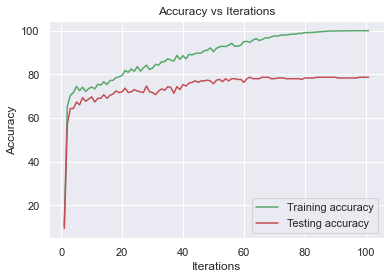

In [278]:
plot_acc(train_acc_list,test_acc_list)

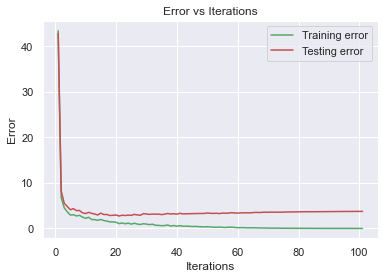

In [279]:
plot_error(train_error_list,test_error_list)

In [193]:
train_acc_list[-1],test_acc_list[-1]

(0.9796296296296296, 0.7)

(<matplotlib.image.AxesImage at 0x26b019e8c08>, 5)

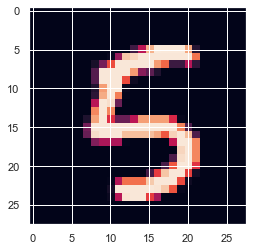

In [258]:
idx = 1
plt.imshow(np.array(Xorig[idx]).reshape(28,28)),Yorig[idx]

In [259]:
nn.f_prop(Xorig[1][:])

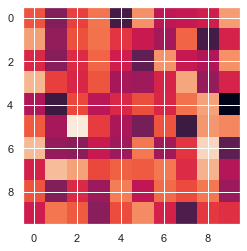

In [264]:
plt.imshow(np.array(nn.z[0]).reshape(10,10))

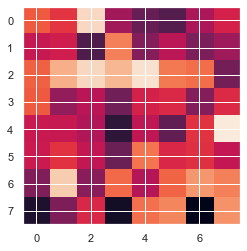

In [262]:
plt.imshow(np.array(nn.z[1]).reshape(8,8))